In [19]:
import gps_walkthrough as gpswt
import numpy as np
import matplotlib.pyplot as plt

Wave recording read. Duration: 0.1280 s


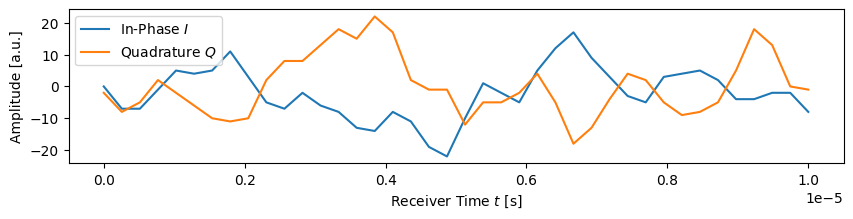

In [20]:
sampling_rate = 4.096e6

# read in the recorded radio wave file (change dtype='byte' for data from `hackrf_transfer`)
baseband = gpswt.SdrWave.from_raw_file('../recorded_data/out-1208-4096-sample.dat', sampling_rate=sampling_rate, 
                                       #, max_samples=100000000)  # limit samples for fast experiments
                                       dtype='byte') 

#baseband = gpswt.SdrWave.from_raw_file('./example-data/gps-sdr-sim-data_1byte_10MSps_10s.dat', sampling_rate=sampling_rate, 
#                                       max_samples=1000000,  # limit samples for fast experiments
#                                       dtype='byte') 

# cut the first 0.1 seconds during antenna power up (ignored)
# baseband = baseband.get_interval(from_time=0.001)
print(f'Wave recording read. Duration: {baseband.duration():0.4f} s')

# visualize a snippet
t0 = 0   # select start time (0.5s)
dt = 1e-5  # time window of 5ms

signal_slice = baseband.get_interval(from_time=t0, to_time=t0+dt)
t = np.linspace(t0, t0+dt, len(signal_slice.samples))

plt.figure(figsize=(10,2))
plt.plot(t, np.real(signal_slice.samples),'-', label='In-Phase $I$')
plt.plot(t, np.imag(signal_slice.samples),'-', label='Quadrature $Q$')
plt.xlabel('Receiver Time $t$ [s]')
plt.ylabel('Amplitude [a.u.]')
plt.legend()
plt.show()

1 0.006000278723980995
2 0.006544972270438535
3 0.0060183252492839
4 0.009659896050242709
5 0.0061035202702348496
6 0.025960163065415022
7 0.006438478674463279
8 0.006610510418902298
9 0.009343723468129695
10 0.008173150060242024
11 0.008192788574680551
12 0.01534692648635757
13 0.0064734344783291976
14 0.008101152382699867
15 0.005942594707299854
16 0.010262973201503921
17 0.008275743597302754
18 0.006326976780860401
19 0.012551419616454245
20 0.007266543372901736
21 0.0063114742853173054
22 0.006621952586609286
23 0.005976342833705797
24 0.006536291024184919
25 0.008403304731993286
26 0.007814798688656286
27 0.006747282307185259
28 0.00599414735443915
29 0.00663463826323365
30 0.005684783742758904
31 0.007765249870990167
32 0.00580660622602583
33 0.007412888388404521
34 0.005986279607874514
35 0.007287921303277567
36 0.007600480616383193
37 0.005986279607874514
Top-5 PRNs: [ 6 12 19 16  4]


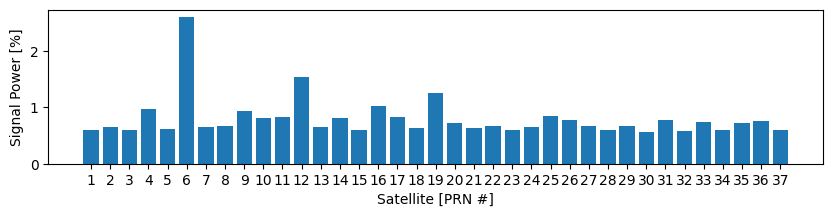

In [86]:
prn_ids = range(1, 38)  # PRN IDs to search for

signal_strength = np.zeros(len(prn_ids))
for i, prn_id in enumerate(prn_ids):
    signal_slice = baseband.get_interval(from_time = 0.008, to_time=0.009)  # take first 50 ms
    #taking less because we have shorter sample.

    acq = gpswt.Acquisition(prn_id, sampling_dt=baseband.sampling_dt)
    acq_data = acq.search(signal_slice,
                          delta_freq_step=100, 
                          delta_freq_range=(-15000,15000)) # increase to 100k for HackRF w/o external clock

    print(prn_id, abs(acq_data['correlator'][0])**2)
    
    signal_strength[i] = np.median(np.abs(acq_data['correlator']**2))  # average power
    # print("prn_id: ",prn_id, " signal strength: ", signal_strength[i])
    # print(f"Doppler Shift: {acq_data['delta_freq'][0]} Hz")
    # print(f"Code Delay:    {acq_data['delay'][0] * 1e6} microseconds")
    # print(f"Carrier Phase: {np.angle(acq_data['correlator'][0]):.2f} radians")

best_prns = np.argsort(-signal_strength)[:5] + 1
print(f'Top-5 PRNs: {best_prns}')

plt.subplots(figsize=(10,2))
plt.bar(prn_ids, signal_strength * 100, tick_label=prn_ids)
plt.xlabel('Satellite [PRN #]')
plt.ylabel('Signal Power [%]')
plt.show()


In [1]:
# ok, clearly PRN 6 should have a high convolution at the correct Doppler

In [42]:
N = 4096

In [43]:
arr = np.array([])

with open('ca.mem', 'r') as f:
    for line in f:
        line = line.strip()
        arr = np.append(arr, 1 if line == '7fff' else -1)

assert arr.size == N  * 37, f"Expected 4096 * 37 values, but got {arr.size}"

reshaped_arr = arr.reshape(37, N)

print(reshaped_arr.shape)  # Should print (37, 4096)

(37, 4096)


In [44]:
reshaped_arr[5, :] # PRN 6

array([1., 1., 1., ..., 1., 1., 1.], shape=(4096,))

In [87]:
# we expect to get to 0.025 for correct doppler

46 -10400 0.025960163065415022


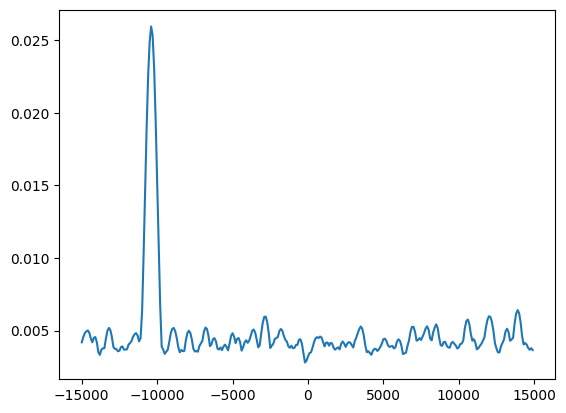

In [90]:
signal_slice = baseband.get_interval(from_time = 0.008, to_time=0.009)  # take 9th ms, empirically worked
signal_slice.samples
signal_slice_rms = np.sqrt(np.sum(np.abs(signal_slice.samples**2)))
ca_code = reshaped_arr[5, :]
prn_fft = np.fft.fft(ca_code)
ca_code_rms = np.sqrt(np.sum(np.abs(ca_code**2)))   # root mean square of code
t = np.arange(0, N) * signal_slice.sampling_dt
amplitudes = []
doppler_range = list(range(-15000, 15000, 100))
for doppler in doppler_range:
    iq_fft = np.fft.fft(signal_slice.samples * np.exp(-1j * 2*np.pi * doppler * t))
    convolve = np.fft.ifft(iq_fft * prn_fft.conj()) / ca_code_rms / signal_slice_rms
    peak_position = np.argmax(abs(convolve))
    amplitudes.append(abs(convolve)[peak_position]**2)
plt.plot(doppler_range, amplitudes)
best_doppler = np.argmax(amplitudes)
print(best_doppler, doppler_range[best_doppler], amplitudes[best_doppler])
